<a href="https://colab.research.google.com/github/tdiffendal/USAT/blob/master/census-responses/census_responses_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 Census Response Rate Analysis

### Theresa Diffendal, USA Today data intern, 06/2020

#### 2020 response rates from: https://2020census.gov/en/response-rates.html
#### 2010 response rates from: https://api.census.gov/data/2010/dec/responserate/variables.html
#### Demographic information in 2014-2018 ACS 5-year-estimate from: https://data2.nhgis.org/main

## Read, Merge, Clean Data

### Initial Load and Merge

In [594]:
import pandas as pd
import numpy as np

In [595]:
#mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [596]:
# merge responses, crosswalk and region
# states paired with region as defined by census map at https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

merged = pd.merge(pd.read_csv('https://www2.census.gov/programs-surveys/decennial/2020/data/2020map/2020/decennialrr2020.csv',
                         dtype={'CRRINT':np.float,
                                'CRRALL':np.float}),
                  pd.read_csv('https://www2.census.gov/programs-surveys/decennial/2020/data/2020map/2020/decennialrr2020_crosswalkfile.csv', encoding='ISO-8859-1'),
                  on='GEO_ID').merge(
                      pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/state_region.csv'),
                          on='State')

# create column showing responses not from internet
merged['not_int'] = merged.CRRALL - merged.CRRINT
merged['not_int_pct'] = (merged.not_int) * 100 / merged.CRRALL

#reorder columns to move State, Geo_Name and Geo_Type to front; also going to drop some values
merged = merged[['GEO_ID','RESP_DATE','State','Geo_Name','Region', 
                 'Geo_Type','CRRINT','not_int','not_int_pct','CRRALL']].rename(
            columns={'CRRINT':'internet', 'CRRALL':'2020_rate'})

In [597]:
merged

,GEO_ID,RESP_DATE,State,Geo_Name,Region,Geo_Type,internet,not_int,not_int_pct,2020_rate
0,0100000US,2020-08-10,NaN,United States,na,Country,50.6,12.7,20.063191,63.3
1,0200000US1,2020-08-10,NaN,Northeast,na,Region,50.8,12.2,19.365079,63.0
2,0200000US2,2020-08-10,NaN,Midwest,na,Region,54.0,14.1,20.704846,68.1
3,0200000US3,2020-08-10,NaN,South,na,Region,46.8,13.5,22.388060,60.3
4,0200000US4,2020-08-10,NaN,West,na,Region,53.7,10.5,16.355140,64.2
...,...,...,...,...,...,...,...,...,...,...
123245,1400000US72153750502,2020-08-10,Puerto Rico,"Tract 7505.02, Yauco",Puerto Rico,Census Tract,27.5,20.2,42.348008,47.7
123246,1400000US72153750503,2020-08-10,Puerto Rico,"Tract 7505.03, Yauco",Puerto Rico,Census Tract,15.7,16.9,51.840491,32.6
123247,1400000US72153750601,2020-08-10,Puerto Rico,"Tract 7506.01, Yauco",Puerto Rico,Census Tract,18.5,16.2,46.685879,34.7
123248,1400000US72153750602,2020-08-10,Puerto Rico,"Tract 7506.02, Yauco",Puerto Rico,Census Tract,9.7,15.0,60.728745,24.7


### States

In [598]:
# create df with response rate by state
states2020 = merged[merged['Geo_Type'] == 'State'].rename(
    columns={"internet": "state_internet",
             "not_int" : "state_not_int",
             'not_int_pct' : 'state_not_int_pct',
             "2020_rate" : "2020_state_rate"})

# read in csvs with 2010 response data for states
states2010 = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/states2010.csv',
                         dtype={'2010_rate':np.float,
                                '2000_rate':np.float})

# merge with 2020 states
states = pd.merge(states2020, states2010, on='State')
#only select columns we want
states = states[['GEO_ID', 'State', 'Region','2020_state_rate', 
                 '2010_rate', '2000_rate']].rename(
                     columns={'2000_rate':'2000_state_rate', 
                              '2010_rate':'2010_state_rate'})

#create column with difference in 2010 vs 2020 response rate
states['10_20_state_difference'] = (states['2020_state_rate'] - states['2010_state_rate']
    ) / states['2010_state_rate'] * 100

#print table sorted by 10-20 difference largest ---> smallest
states.sort_values(by=['10_20_state_difference'], ascending=True)

,GEO_ID,State,Region,2020_state_rate,2010_state_rate,2000_state_rate,10_20_state_difference
51,0400000US72,Puerto Rico,Puerto Rico,28.8,54.0,54.0,-46.666667
40,0400000US45,South Carolina,South,57.5,75.0,68.0,-23.333333
1,0400000US02,Alaska,West,50.0,64.0,67.0,-21.875000
33,0400000US37,North Carolina,South,59.4,76.0,69.0,-21.842105
9,0400000US12,Florida,South,60.2,74.0,71.0,-18.648649
19,0400000US23,Maine,Northeast,55.6,68.0,67.0,-18.235294
10,0400000US13,Georgia,South,59.0,72.0,72.0,-18.055556
43,0400000US48,Texas,South,58.3,71.0,70.0,-17.887324
31,0400000US35,New Mexico,West,53.5,65.0,68.0,-17.692308
42,0400000US47,Tennessee,South,62.6,76.0,72.0,-17.631579


### Census Tracts

In [599]:
# select just census tract geo types
tracts2020 = merged[merged['Geo_Type'].str.contains("Tract")].rename(
    columns={"2020_rate": "2020_tract_rate",'not_int':'tract_not_int',
             'not_int_pct':'tract_not_int_pct'}).sort_values(
                 by='2020_tract_rate', ascending=False)

# give tribal tracts state and regional values "Tribal Land"
tracts2020.loc[tracts2020['Geo_Type'].str.contains("Tribal")==True, 'Region'] = 'Tribal Land'
tracts2020.loc[tracts2020['Geo_Type'].str.contains("Tribal")==True, 'State'] = 'Tribal Land'

In [600]:
tracts2020.sort_values(by=['State', 'GEO_ID'])

,GEO_ID,RESP_DATE,State,Geo_Name,Region,Geo_Type,internet,tract_not_int,tract_not_int_pct,2020_tract_rate
814,1400000US01001020100,2020-08-10,Alabama,"Tract 201, Autauga",South,Census Tract,59.8,6.8,10.210210,66.6
815,1400000US01001020200,2020-08-10,Alabama,"Tract 202, Autauga",South,Census Tract,36.7,29.9,44.894895,66.6
816,1400000US01001020300,2020-08-10,Alabama,"Tract 203, Autauga",South,Census Tract,65.4,10.2,13.492063,75.6
817,1400000US01001020400,2020-08-10,Alabama,"Tract 204, Autauga",South,Census Tract,68.7,10.2,12.927757,78.9
818,1400000US01001020501,2020-08-10,Alabama,"Tract 205.01, Autauga",South,Census Tract,71.0,8.6,10.804020,79.6
...,...,...,...,...,...,...,...,...,...,...
122146,1400000US56043000200,2020-08-10,Wyoming,"Tract 2, Washakie",West,Census Tract,21.0,34.0,61.818182,55.0
122147,1400000US56043000301,2020-08-10,Wyoming,"Tract 3.01, Washakie",West,Census Tract,49.4,12.1,19.674797,61.5
122148,1400000US56043000302,2020-08-10,Wyoming,"Tract 3.02, Washakie",West,Census Tract,56.0,11.4,16.913947,67.4
122149,1400000US56045951100,2020-08-10,Wyoming,"Tract 9511, Weston",West,Census Tract,31.7,16.7,34.504132,48.4


In [601]:
#tract rates compared to state averages
all20 = pd.merge(tracts2020, states, on=['State', 'Region'])

print(
    "Difference in records:", len(tracts2020) - len(all20),
    "\nNumber of tribal tracts:", len(tracts2020[tracts2020['Geo_Type'].str.contains(
        "Tribal")]),
    "\n\n", "merging tracts with states will drop tribal tracts",
    "\n(as they have no state), so those are examined separately below"
)

all20['2020_tract_st_diff'] = all20['2020_tract_rate'] - all20['2020_state_rate']
all20 = all20[['GEO_ID_x', 'State', 'Geo_Name', 'Geo_Type',
               'Region','2020_tract_rate', '2020_state_rate',
               '2010_state_rate', '10_20_state_difference','2020_tract_st_diff']
              ].rename(columns={'GEO_ID_x':'GEO_ID'}).sort_values(by=['2020_tract_st_diff'])

Difference in records: 426 
Number of tribal tracts: 426 

 merging tracts with states will drop tribal tracts 
(as they have no state), so those are examined separately below


In [602]:
# read in csvs with 2010 response data for tracts and states
tracts2010 = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/2010responserate.csv',
                         dtype={'FSRR2010':np.float}).rename(
                             columns={'FSRR2010':'2010_tract_rate'})

# merge with 2020 tracts
tracts = pd.merge(all20, tracts2010, on='GEO_ID')

#create column with difference in 2010 vs 2020 response rate
tracts['10_20_tract_difference'] = (tracts['2020_tract_rate'] - tracts['2010_tract_rate']) / tracts['2010_tract_rate'] * 100

#select only columns we want
tracts = tracts[['Geo_Name','county', 'State_y', 'Region', 'Geo_Type', 
                 '2020_tract_rate', '2010_tract_rate', '10_20_tract_difference', 
                 '2020_tract_st_diff', '2020_state_rate','2010_state_rate', 
                 '10_20_state_difference','GEO_ID']].rename(
            columns={'State_y':'State'}).sort_values(by='2010_tract_rate', ascending=False)

### Demographic Data

In [603]:
#load census demographic data, join

## internet access data
temp = pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_internet_access/ACSDT5Y2018.B28002_data_with_overlays_2020-07-02T154751.csv',
                    usecols = [0,1,2,26],
                    names = ['GEO_ID', 'NAME','total_comp', 'no_int'],
                    dtype={'total_comp':np.int, 'no_int':np.int},
                    skiprows=2)

#create new column to get % without internet instead of whole number
temp['no_int_pct'] = temp.no_int * 100 / temp.total_comp 
temp = temp[['GEO_ID', 'NAME', 'no_int_pct']]

## some weirds NAs, so to turn all columns to float:
def valid_float(y):
  try:
    return float(y)
  except ValueError:
    return np.nan

## demographics data
frames = [pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_demographics/ACSDP5Y2018.DP05_data_with_overlays_2020-07-02T144029.csv',
                    usecols = [0,1,2,70,148,152,156,176,208,228,232,284,304,342],
                    names = ['GEO_ID', 'NAME','total_population','median_age', 
                             'white_pct','black_pct','native_pct','asian_pct',
                             'pacific_pct','other_pct','two_pct','latino_pct',
                             'notLatino_pct','house_units'], 
                    skiprows= 1,
                    dtype={'total_population':np.int,'house_units':np.int},
                    converters={'median_age':valid_float,'white_pct':valid_float,
                                'black_pct':valid_float,'native_pct':valid_float,
                                'asian_pct':valid_float,'pacific_pct':valid_float,
                                'other_pct':valid_float,'two_pct':valid_float,
                                'latino_pct':valid_float,'notLatino_pct':valid_float,}),
           pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_housing/ACSDP5Y2018.DP04_data_with_overlays_2020-07-02T161352.csv',
                    usecols = [0,1,8,12,184,188,300,354,568],
                    names = ['GEO_ID', 'NAME','occupied_pct','vacant_pct',
                             'owner_pct','renter_pct','no_telephone_pct',
                             'median_value','rent_more_35_pct'],
                    converters={'occupied_pct':valid_float,
                                'vacant_pct':valid_float,
                                'owner_pct':valid_float,
                                'renter_pct':valid_float,
                                'no_telephone_pct':valid_float,
                                'median_value':valid_float,
                                'rent_more_35_pct':valid_float},
                    skiprows=2),
          pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_income/ACSST5Y2018.S1901_data_with_overlays_2020-07-02T160659.csv',
                    usecols = [0,1,90],
                    names = ['GEO_ID', 'NAME','median_income'],
                    converters={'median_income':valid_float},
                    skiprows=2),
          temp]

from functools import reduce
demo = reduce(lambda  left,right: pd.merge(left,right,on=['GEO_ID', 'NAME'],
                                           how='left'), frames)

In [604]:
## read in 2010-2020 census tract crosswalk info
crosswalk = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/rr_tract_rel.csv',
                    usecols = [3,9],
                    names = ['GEO10', 'GEO20'],
                    skiprows=1,
                    dtype={'GEO10':object, 'GEO20':object})

#fill out GEO IDs; should be 11 long
def fill_zeros(x):
    if len(x) < 11:
      return x.zfill(11)
    elif len(x) >= 11:
      return x

crosswalk['GEO10'] = crosswalk['GEO10'].apply(fill_zeros) 
crosswalk['GEO20'] = crosswalk['GEO20'].apply(fill_zeros)

#merge with ACS
##need to change existing GEO IDs to match crosswalk format
demo['GEO10'] = demo['GEO_ID'].str[9:]
tracts['GEO20'] = tracts['GEO_ID'].str[9:]
df = pd.merge(demo, crosswalk, on="GEO10", how="inner").merge(
    tracts, on='GEO20', how="inner").rename(columns={'GEO_ID_x':'GEO_ID'}).drop('GEO_ID_y', axis=1)

In [605]:
#only select columns we want
df = df[['Geo_Name', 'county', 'State', '2020_tract_rate',
 '2010_tract_rate', '10_20_tract_difference', '2020_tract_st_diff', 
 '2020_state_rate', '2010_state_rate', '10_20_state_difference', 
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct',
 'house_units', 'occupied_pct', 'vacant_pct','owner_pct', 'renter_pct', 
 'no_telephone_pct', 'median_value', 'rent_more_35_pct', 'median_income', 
 'no_int_pct', 'Region', 'GEO_ID']]

In [606]:
#strip space in front of character columns
df.State = df.State.str.lstrip()
df.county = df.county.str.lstrip()

### COVID 19 IN PROGRESS DOES NOT WORK

In [621]:
# need to create county FIPS for joining
df['FIPS'] = df['GEO_ID'].str[9:14]

In [626]:
temp = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
temp = temp.iloc[:, np.r_[0:11, -1]].rename(columns={temp.columns[-1]: "case_count", "Province_State":"State"})
temp['FIPS'] = temp['FIPS'].astype(str).replace('\.0', '', regex=True)

## some fips leading zeros were cut, should be 5 long
def fill_zeros(x):
    if x == 'nan':
      return np.nan
    if len(x) < 5:
      return x.zfill(5)
    elif len(x) >= 5:
      return x

temp['FIPS'] = temp['FIPS'].apply(fill_zeros)
temp.FIPS.value_counts()

48283    1
38029    1
26097    1
02170    1
49007    1
        ..
48255    1
27131    1
18001    1
06049    1
08025    1
Name: FIPS, Length: 3330, dtype: int64

In [630]:
# difference in covid and df

# Identify what values are in df and not in temp
key_diff1 = pd.DataFrame(list(set(df.FIPS).difference(temp.FIPS))
).rename(columns={0:'FIPS'})

# Identify what values are in temp and not in df
key_diff2 = pd.DataFrame(list(set(temp.FIPS).difference(df.FIPS))
).rename(columns={0:'FIPS'})

print("There are", len(df), "observations in the df and \n",
    "There are", len(temp), "observations in temp, \n",
    "a difference of", len(df) - len(temp), "\n\n",
    "There are", len(key_diff1), 
    "counties in df that are not in temp \n",
    "And there are", len(key_diff2), "counties in temp not in df\n")

blah = pd.merge(temp, key_diff2, on='FIPS')
blah

There are 103520 observations in the df and 
 There are 3340 observations in temp, 
 a difference of 100180 

 There are 0 counties in df that are not in temp 
 And there are 115 counties in temp not in df



,UID,iso2,iso3,code3,FIPS,Admin2,State,Country_Region,Lat,Long_,Combined_Key,case_count
0,16,AS,ASM,16,00060,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",0
1,316,GU,GUM,316,00066,NaN,Guam,US,13.444300,144.793700,"Guam, US",418
2,580,MP,MNP,580,00069,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",49
3,850,VI,VIR,850,00078,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",547
4,84002060,US,USA,840,02060,Bristol Bay,Alaska,US,58.745140,-156.701064,"Bristol Bay, Alaska, US",10
...,...,...,...,...,...,...,...,...,...,...,...,...
119,84070016,US,USA,840,NaN,Central Utah,Utah,US,39.372319,-111.575868,"Central Utah, Utah, US",426
120,84070017,US,USA,840,NaN,Southeast Utah,Utah,US,38.996171,-110.701396,"Southeast Utah, Utah, US",113
121,84070018,US,USA,840,NaN,Southwest Utah,Utah,US,37.854472,-111.441876,"Southwest Utah, Utah, US",3223
122,84070019,US,USA,840,NaN,TriCounty,Utah,US,40.124915,-109.517442,"TriCounty, Utah, US",179


In [623]:
ddf = pd.merge(df, temp, how='right', on=['State', 'FIPS'])
ddf.loc[(pd.isna(ddf.case_count))]

,Geo_Name,county,State,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct,Region,GEO_ID,FIPS,UID,iso2,iso3,code3,Admin2,Country_Region,Lat,Long_,Combined_Key,case_count


In [617]:
len(ddf)
#len(df)

103444

In [618]:
#check if any nas
pd.set_option('display.max_rows', 70)
print(pd.isna(ddf).sum())

Geo_Name                     0
county                       0
State                        0
2020_tract_rate              0
2010_tract_rate            694
10_20_tract_difference     703
2020_tract_st_diff           0
2020_state_rate              0
2010_state_rate              0
10_20_state_difference       0
total_population             0
median_age                 222
white_pct                  207
black_pct                  207
native_pct                 207
asian_pct                  207
pacific_pct                207
other_pct                  207
two_pct                    207
latino_pct                 207
notLatino_pct              207
house_units                  0
occupied_pct               249
vacant_pct                 249
owner_pct                  273
renter_pct                 273
no_telephone_pct          1145
median_value              1991
rent_more_35_pct           420
median_income              580
no_int_pct                 273
Region                       0
GEO_ID  

In [ ]:
#see what percent of state tracts have lower response
temp1 = pd.merge(pd.DataFrame(temp['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_cov'}),
    pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
    on=['state'])

temp1['cov_percent'] = (temp1['count_cov']*100) / temp1['count']

temp1.count_cov.sum()
l

3334

### County 2016 Presidential Votes

In [264]:
#read in county-level voting information for the 2016 pres race
votes = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/countypres_2016.csv',
                         usecols = [1,3,4,7,8,9],
                   skiprows=1,
                   names= ['State', 'county', 'FIPS', 'party', 
                           'candidatevotes', 'totalvotes'],
                    dtype={'State':np.str, 'county':np.str, 'FIPS':np.float, 
                           'party':np.str,'candidatevotes':np.float, 
                           'totalvotes':np.float})


In [282]:
# difference in voting rows and df

# Identify what values are in df and not in votes
key_diff1 = pd.DataFrame(list(set(df.county).difference(votes.county))
).rename(columns={0:'county'})

# Identify what values are in crosswalk and not in demo
key_diff2 = pd.DataFrame(list(set(votes.county).difference(df.county))
).rename(columns={0:'county'})

print("There are", len(df), "observations in the df and \n",
    "There are", len(votes), "observations in votes, \n",
    "a difference of", len(df) - len(votes), "\n\n",
    "There are", len(key_diff1), 
    "counties in df that are not in votes \n",
    "And there are", len(key_diff2), "counties in votes not in df\n")

key_diff1

There are 103520 observations in the df and 
 There are 3157 observations in votes, 
 a difference of 100363 

 There are 103 counties in df that are not in votes 
 And there are 44 counties in votes not in df



,county
0,Carolina Municipio
1,Bethel Census Area
2,Santa Isabel Municipio
3,Orocovis Municipio
4,Guayama Municipio
5,Southeast Fairbanks Census Area
6,Añasco Municipio
7,Peñuelas Municipio
8,Guánica Municipio
9,Denali Borough


In [ ]:
vote_merge = pd.merge(df, votes, on=(['county', 'State']), how='inner')

In [242]:
## get data on counties by political party

print("\npercent tracts voted republican:",
    len(df[df.party=='republican']) * 100 / len(df),
    "\n\n500 tracts with the greatest response rate % change:\n",
    df.sort_values(by="10_20_tract_difference", ascending=False).head(500).party.value_counts(),
    "\n\n500 tracts with the lowest response rate % change:\n",
    df.sort_values(by="10_20_tract_difference", ascending=True).head(500).party.value_counts(),
    "\n won't exactly=500 as there are some counties for which we dont have pres data"
    )

    ## only 6 tracts with 0 2020 response rate
    ## 86 tracts with 0 2010 response rate 


percent tracts voted republican: 47.57931334202521 

500 tracts with the greatest response rate % change:
 democrat      268
republican    228
Name: party, dtype: int64 

500 tracts with the lowest response rate % change:
 democrat      161
republican    120
Name: party, dtype: int64 
 won't exactly=500 as there are some counties for which we dont have pres data


In [252]:
#check if any nas
print(pd.isnull(df).sum())

Geo_Name                    44
county                       0
State                        0
2020_tract_rate             44
2010_tract_rate            736
10_20_tract_difference     745
2020_tract_st_diff          44
2020_state_rate             44
2010_state_rate             44
10_20_state_difference      44
total_population            44
median_age                 265
white_pct                  251
black_pct                  251
native_pct                 251
asian_pct                  251
pacific_pct                251
other_pct                  251
two_pct                    251
latino_pct                 251
notLatino_pct              251
house_units                 44
occupied_pct               293
vacant_pct                 293
owner_pct                  316
renter_pct                 316
no_telephone_pct          1188
median_value              2014
rent_more_35_pct           459
median_income              614
no_int_pct                 316
Region                      44
FIPS_x  

In [246]:
df.loc[(pd.isna(df.candidatevotes))].State.value_counts()

Puerto Rico    1227
Alaska          130
New Mexico       94
Virginia         53
Florida          12
Hawaii            1
Name: State, dtype: int64

### Check Data

In [136]:
#how many null 2010 response values are there
no_2010 = tracts[tracts.isnull().any(axis=1)].sort_values(by="2010_tract_rate")

print(
    "There are", len(no_2010), "null 2010 response rate values out of", 
    len(tracts2010), "total 2010 observations, \n or",
    len(no_2010) * 100 / len(tracts2010) , "% \n",
    "and", len(no_2010) * 100 / len(tracts), "% of the", len(tracts),
    "total of 2020 and 2010 tracts \n\n",
    "Null response rate tracts in each state:\n",
    no_2010['State'].value_counts())

There are 536 null 2010 response rate values out of 84519 total 2010 observations, 
 or 0.6341769306309823 % 
 and 0.6373895568002093 % of the 84093 total of 2020 and 2010 tracts 

 Null response rate tracts in each state:
  Wisconsin               92
 Florida                 56
 Texas                   54
 California              54
 New York                51
 Arizona                 51
 New Mexico              30
 Massachusetts           21
 Washington              17
 Montana                 14
 South Dakota            13
 North Carolina           8
 Minnesota                7
 Alabama                  7
 North Dakota             6
 Colorado                 6
 Utah                     6
 Idaho                    6
 Wyoming                  6
 New Hampshire            3
 Vermont                  3
 Maine                    3
 Nevada                   3
 Virginia                 3
 Michigan                 2
 Oklahoma                 2
 New Jersey               2
 Nebraska           

In [ ]:
# Identify what values are in tracts2010 and not in tracts2020
key_diff1 = pd.merge(
    pd.DataFrame(list(set(tracts2010.GEO_ID).difference(tracts2020.GEO_ID))
    ).rename(columns={0:'GEO_ID'}), 
    tracts2010, on='GEO_ID', how='left')

# Identify what values are in tracts2020 and not in tracts2010
key_diff2 = pd.merge(
    pd.DataFrame(list(set(tracts2020.GEO_ID).difference(tracts2010.GEO_ID))
    ).rename(columns={0:'GEO_ID'}), 
    tracts2020, on='GEO_ID', how='left')

print("merged tracts length:", len(tracts), 
      "\n tracts10:", len(tracts2010),
      "\n tracts20:", len(tracts2020),
      "\n number tracts10 missing from tracts20:", len(key_diff1),
      "\n number tracts20 missing from tracts10:", len(key_diff2),
      "\ntotal missing:", (len(tracts2010)-len(tracts)) + (len(tracts2020) - len(tracts)),
      "\n2010 rates do not include the", len(key_diff2), "tribal tracts \nwhich is",
      len(key_diff2)/len(tracts2010)*100, '% of the original', len(tracts2010), 
      'tracts. \nThese tracts are dropped in the comparative analyses and are analyzed separately')

In [ ]:
# #Obs in each df
print(
    "crosswalk records:",len(crosswalk),
    "\ndemographic records:",len(demo),
    "\ntracts:", len(tracts),
    "\nACS:", len(demo),
    "\ncrosswalk:", len(crosswalk),
    "\nall:", len(df)
)

In [ ]:
## difference in 2020 row numbers
# Identify what values are in tracts and not in crosswalk
key_diff1 = pd.DataFrame(list(set(tracts.GEO20).difference(crosswalk.GEO20))
).rename(columns={0:'GEO_ID'})

# Identify what values are in crosswalk and not in tracts
key_diff2 = pd.DataFrame(list(set(crosswalk.GEO20).difference(tracts.GEO20))
).rename(columns={0:'GEO_ID'})

print("There are", len(tracts), "observations in the tracts df and \n",
    "There are", len(crosswalk), "observations in the crosswalk df, \n",
    "a difference of", len(crosswalk) - len(tracts), "\n\n",
    "There are", len(key_diff1), 
    "tracts in the tracts df that are not in the crosswalk df \n",
    "And there are", len(key_diff2), "tracts in the crosswalk df not in the tracts df")

In [ ]:
## difference in 2010 row numbers
# Identify what values are in demo and not in crosswalk
key_diff1 = pd.DataFrame(list(set(demo.GEO10).difference(crosswalk.GEO10))
).rename(columns={0:'GEO_ID'})

# Identify what values are in crosswalk and not in demo
key_diff2 = pd.DataFrame(list(set(crosswalk.GEO10).difference(demo.GEO10))
).rename(columns={0:'GEO_ID'})

print("There are", len(demo), "observations in the demo df and \n",
    "There are", len(crosswalk), "observations in the crosswalk df, \n",
    "a difference of", len(crosswalk) - len(demo), "\n\n",
    "There are", len(key_diff1), 
    "tracts in the demo df that are not in the crosswalk df \n",
    "And there are", len(key_diff2), "tracts in the crosswalk df not in the demo df\n")

In [ ]:
#check for duplicate rows
df[df.duplicated(keep='first')]
print(len(df[df.duplicated(keep='first')]), "duplicate rows")

#drop duplicate rows
df=df.drop_duplicates(keep="first")

In [ ]:
#check if any nas
print(pd.isnull(df).sum())

In [ ]:
# make a dataframe of all rows with na value
temp1 = df[df.isna().any(axis=1)]

#see what percent of state values of na
temp2 = pd.merge(pd.DataFrame(temp1['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_na'}),
                 pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                 on=['state'])

temp2['na_percent'] = (temp2['count_na']*100) / temp2['count']

print(
    "Total na tracts:", sum(temp2['count_na']),
    '\nNAs as % of all tracts:', (sum(temp2['count_na'])*100) / sum(temp2['count']),
    "\n",temp2)

In [ ]:
#how many inf tract difference values are there
temp = df.loc[(df['10_20_tract_difference'] == np.inf) | (df['10_20_tract_difference'] == -np.inf)].sort_values(by="2010_tract_rate")

print(
    "There are", len(temp), "inf response rate values out of", len(df), 
    "total  observations, \n or", len(temp) * 100 / len(df) , 
    "% \n\nInf response rate tracts in each state:\n",
    temp['State'].value_counts())

## Analysis without Puerto Rico

In [ ]:
##see all dfs in memory
%whos DataFrame

#### Existing DFs:

# df: dataframe with all years, states, tracts, demographics

# states: 2010 and 2020 state rates
# states2010: 2010 State rates
# states2020: 2020 State rates

# tracts: 2010 and 2020 tract and state rates
# tracts2010: 2010 tract rates
# tracts2020: 2020 tract rates

# all20: 2020 tracts paired with states, includes internet data

# merged: all 2020 rates by multiple geo types
# no_2010: tracts with a null 2010 response rate value
# demo: 2014-2018 ACS information for 2010 census tract boundaries

# ignore all dfs with "temp" in name 

In [ ]:
### Without Puerto Rico
# get rid of inf and nan values to calculate averages

#make non-pr df
npr = df[df.State != 'Puerto Rico'].replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
# get average state rate and see how many are above average
temp = (states['2020_state_rate'] >= states['2010_state_rate'])

print(
    "63.3% is the current nationwide response rate \n\n",
    np.sum(temp),"states have reached or exceeded their 2010 response rate:\n\n",
    states[temp].State, "\n\n",
        states[temp].Region.value_counts())

### 2010-2020 Changes

In [ ]:
#how many tracts have lower response rate than in 2010
lower = npr.loc[(npr['2020_tract_rate'] < npr['2010_tract_rate']
            )].sort_values(
        by='10_20_tract_difference', ascending=True)
            
#see what percent of state tracts have lower response
temp = pd.merge(pd.DataFrame(lower['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_lower'}),
    pd.DataFrame(npr['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
    on=['state'])

temp['lower_percent'] = (temp['count_lower']*100) / temp['count']

print(
    "Total lower tracts:", sum(temp['count_lower']),
    '\nLowers as % of all tracts:', 
    (sum(temp['count_lower'])*100) / sum(temp['count']), "\n",
    len(lower), "of", len(npr), "total tracts, or", len(lower)*100/len(npr), "% have lower \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="lower_percent"), "\n\n")

In [ ]:
#lower by region
temp = pd.merge(pd.DataFrame(lower['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_lower'}),
    pd.DataFrame(npr['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count'}),
    on=['Region'])

temp['lower_percent'] = (temp['count_lower']*100) / temp['count']

print(
    "Total lower tracts:", sum(temp['count_lower']),
    '\nLowers as % of all tracts:', 
    (sum(temp['count_lower'])*100) / sum(temp['count']), "\n",
    len(lower), "of", len(npr), "total tracts, or", len(lower)*100/len(npr), "% have lower \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="lower_percent"), "\n\n",)

In [ ]:
#tracts with 2020 response rate > 2010
higher = npr.loc[(npr['2020_tract_rate'] > npr['2010_tract_rate']
            )].sort_values(
        by='10_20_tract_difference', ascending=True)
            
temp = pd.merge(pd.DataFrame(higher['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_higher'}),
                pd.DataFrame(npr['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                on=['state'])

temp['higher_percent'] = (temp['count_higher']*100) / temp['count']

print(
    "Total higher tracts:", sum(temp['count_higher']),
    '\nHighers as % of all tracts:', 
    (sum(temp['count_higher'])*100) / sum(temp['count']), "\n",
    len(higher), "of", len(npr), "total tracts, or", len(higher)*100/len(npr), "% have higher \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="higher_percent"), "\n\n")

In [ ]:
# some stats on tracts with lower and higher rates
display("higher",higher.describe(),
        "reg",npr.describe(),
        "Lower", lower.describe())
print('Higher rates vote:\n', higher.party.value_counts(),
      '\n\nnpr rates vote:\n', npr.party.value_counts(),
      '\n\nLower rates vote:\n', lower.party.value_counts())

In [ ]:
# get info on 1000 tracks with greatest drop in response rate
big_drop = npr.loc[(
    npr['10_20_tract_difference'] > -100) & (
    npr['10_20_tract_difference'] < 0)].sort_values(
                  by='10_20_tract_difference', ascending=True).head(1000)
  
#big_drop by region
temp = pd.merge(pd.DataFrame(big_drop['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_drop'}),
    pd.DataFrame(npr['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count'}),
    on=['Region'])

temp['drop_percent'] = (temp['count_drop']*100) / temp['count']

print(
    "Total big drop tracts:", sum(temp['count_drop']),
    '\nBig drops as % of all tracts:', 
    (sum(temp['count_drop'])*100) / sum(temp['count']),
    "\n\n", temp)

In [ ]:
# temp with tracts less than half 2010 rate

temp = npr.loc[(npr['10_20_tract_difference'] > -100) & (npr['10_20_tract_difference'] <= -50)]
temp1 = pd.merge(pd.DataFrame(temp['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_half'}),
    pd.DataFrame(npr['Region'].value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_all'}),
    on=['Region'])

temp1['pct_half']= temp1.count_half * 100 / temp1.count_all

print(len(temp), "or", len(temp) / len(npr) * 100,
      "% of tracts have a 2020 response rate \n half or less than half their 2010 rate\n\n",
      "By region:\n", temp1,
      "\n\nBy state:\n", temp.State.value_counts())

In [ ]:
# biggest increases in response rates
# get info on 1000 tracks with greatest gain in response rate
big_gain = npr.loc[(npr['10_20_tract_difference'] > 0) & (
    npr['2010_tract_rate'] != 0)].sort_values(
                  by='10_20_tract_difference', ascending=False).head(1000)
print("By region:\n", big_gain.Region.value_counts(),
      "\n\nBy state:\n", big_gain.State.value_counts())

In [ ]:
# some stats on biggest gains and drops
display("biggest gains:",big_gain.describe().round(1),
"average:",npr.describe().round(1),
"biggest drops:",big_drop.head(1000).describe().round(1))

In [ ]:
#info on drops and gains by party
print('Gains vote:\n', big_gain.party.value_counts(),
      '\n\nnpr vote:\n', npr.party.value_counts(),
      '\n\nDrops vote:\n', big_drop.party.value_counts(), "\n\n")
display(big_gain.groupby('party').describe())
display(npr.groupby('party').describe())
display(big_drop.groupby('party').describe())

In [ ]:
# how many tracts have 2020 rate double their 2010 rate
print(len(big_gain[big_gain['10_20_tract_difference'] >= 1]) * 100 / len(npr),
      "% of tracts have a 2020 response rate at least double their 2010 rate")

### Race / Ethnicity

In [ ]:
npr['latinoBins'] = pd.cut(npr['latino_pct'], bins=[0, 10, 25, 33, 50, 75, 90, 100],
                           labels=['0_10', '10_25', '25_33', '33_50', '50_75', '75_90', '90_100'],
                           precision=0)
npr.groupby('latinoBins').describe()

In [ ]:
# compare Texas high percentage Latino tracts to total # tracts in county

temp = pd.merge(pd.DataFrame(npr.loc[(npr.State == 'Texas') & (npr.latinoBins == '90_100')].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'maj_Latino'}),
                 pd.DataFrame(npr.loc[(npr.State == 'Texas')].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'total'}),
                 how='left')

#calculate what % all tracts is 95% or more Latino in Texas
temp['maj_Latino_pct'] = (temp['maj_Latino']*100) / temp['total']

print(
    "Total majority (90%) latino tracts in Texas:", sum(temp['maj_Latino']),
    '\nMajority Latino as % of all Texas tracts:', (sum(temp['maj_Latino'])*100) / sum(temp['total']),
    "\n\n",temp)

In [ ]:
display(
    "maj Latino",
    npr.loc[(npr.State == 'Texas') & (npr.latinoBins == '90_100')].groupby('county').describe(),
    'all Texas',
    pd.DataFrame(npr.loc[(npr.State == 'Texas')]).groupby(by='county').describe())

In [ ]:
npr['asianBins'] = pd.cut(npr['asian_pct'], bins=[0, 10, 25, 33, 50, 75, 90, 100],
                               labels=['0_10', '10_25', '25_33', '33_50', '50_75', '75_90', '90_100'],
                            precision=0)
npr.groupby('asianBins').describe()

In [ ]:
npr['blackBins'] = pd.cut(npr['black_pct'], bins=[0, 10, 25, 33, 50, 75, 90, 100],
                               labels=['0_10', '10_25', '25_33', '33_50', '50_75', '75_90', '90_100'],
                            precision=0)
npr.groupby('blackBins').describe()

In [ ]:
npr['whiteBins'] = pd.cut(npr['white_pct'], bins=[0, 10, 25, 33, 50, 75, 90, 100],
                               labels=['0_10', '10_25', '25_33', '33_50', '50_75', '75_90', '90_100'],
                            precision=0)
npr.groupby('whiteBins').describe()

In [ ]:
npr['nativeBins'] = pd.cut(npr['native_pct'], bins=[0, 10, 25, 33, 50, 75, 90, 100],
                               labels=['0_10', '10_25', '25_33', '33_50', '50_75', '75_90', '90_100'],
                            precision=0)
npr.groupby('nativeBins').describe()

### Region Analysis

In [ ]:
# Regional descriptions
display(npr.groupby('Region').describe().round(2))

### Politics

In [ ]:
pd.set_option('display.max_columns', None)
npr.groupby('party').describe()

In [ ]:
print("drop:\n", big_drop.head(1000).party.value_counts(),
        "\n\ngain:\n", big_gain.party.value_counts())

### Tribal tracts

In [ ]:
# create df with response rates in tribal tracts
tribal = tracts2020[tracts2020['Geo_Type'].str.contains("Tribal")]
tribal.describe()

In [ ]:
### tribal areas and tracts stats

#mean non internet response
print("Average % non-int response tribal:", 
      tribal.mean(axis=0)['tract_not_int_pct'], "%")

In [ ]:
# mean overall response rate
print("Tribal average response rate:",
      tribal.mean(axis=0)['2020_tract_rate'], "%")

### Internet Usage

Internet usage is only available for 2020 rates

In [ ]:
### Percent of response rate not from internet

print(
    "The average state response rate to the census NOT conducted online:",
    states2020[states2020.State != 'Puerto Rico'].mean(axis=0)['state_not_int_pct'])

# average non internet response rate
#states2020[states2020.State != 'Puerto Rico'].groupby(by='State').mean().sort_values(
#    by='state_not_int_pct', ascending=False).merge(state_ranks, on='State')

### Tracts with 0 overall response rate

In [ ]:
## Tracts with 0 cumulative response rate
zeros = npr[npr['2020_tract_rate'] == 0]



print("Number of tracts with 0 cumulative response rate:", len(zeros), 
      "\nNumber tracts with 0 change:", len(npr[npr['10_20_tract_difference'] == 0]))

#return data frame with each tract with 0 2020 response rate
zeros.sort_values(by='State')

### Graphs

In [ ]:
#make graphs
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook

In [ ]:
# bin response rates
npr['rateBins'] = pd.cut(npr['10_20_tract_difference'],
                         bins=[-100, -50, 0, 50, 100],
                         labels=['-100_50', '-50_0', '0_50', '50_100'],
                            precision=0)
npr.groupby('rateBins').describe()

In [ ]:
# native % vs rate bins

temp = npr[['State','10_20_tract_difference', 'nativeBins']]
temp['10_20_tract_difference'] = temp['10_20_tract_difference']

temp = temp.groupby('nativeBins').mean()
x = temp.index
y = temp['10_20_tract_difference']

#create mean line
#y_mean = [np.mean(y)]*len(x)
#fig,ax = plt.subplots()

# plotting the points  
plt.plot(x, y)

# Plot the average line
#mean_line = ax.plot(x,y_mean, label='Mean', linewidth=1, linestyle='--')

#change y axis limits
plt.ylim([-50,1])

# naming the x axis 
plt.xlabel('% Native') 
# naming the y axis 
plt.ylabel('%Response Change') 
# giving a title to my graph 
plt.title('% Native Compared to % Tract Response Rate Change')
# Make a legend
legend = ax.legend(loc='upper right')

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/no_comp_change_npr.png',
#            bbox_inches='tight')

# function to show the plot 
plt.show()


In [ ]:
# latino % vs rate bins

temp = npr[['State','10_20_tract_difference', 'rateBins', 'latino_pct']]
temp['10_20_tract_difference'] = temp['10_20_tract_difference']

temp = temp.groupby('rateBins').mean()
x = temp.index
y = temp['latino_pct']

# plotting the points  
plt.plot(x, y)

#change y axis limits
plt.ylim([10,30])

# naming the x axis 
plt.xlabel('%Response Change') 
# naming the y axis 
plt.ylabel('Avg % Latino') 
# giving a title to my graph 
plt.title('% Tract Response Rate Change vs % Latino')
# Make a legend
legend = ax.legend(loc='upper right')

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/no_comp_change_npr.png',
#            bbox_inches='tight')

# function to show the plot 
plt.gca().coord_flip()
plt.show()


In [ ]:
## comp vs tract change

x = npr.no_int_pct
y = npr['10_20_tract_difference'] / 100

#create mean line
y_mean = [np.mean(y)]*len(x)
fig,ax = plt.subplots()

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

# Plot the average line
mean_line = ax.plot(x,y_mean, label='Mean', linewidth=1, linestyle='--')

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% No Computers') 
# naming the y axis 
plt.ylabel('Response Change') 
# giving a title to my graph 
plt.title('% No Computers Compared to Tract Response Rate Change')
# Make a legend
legend = ax.legend(loc='upper right')

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/no_comp_change_npr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
## latino vs tract change

x = npr.latino_pct
y = npr['10_20_tract_difference'] / 100

#create mean line
y_mean = [np.mean(y)]*len(x)
fig,ax = plt.subplots()

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

# Plot the average line
mean_line = ax.plot(x,y_mean, label='Mean', linewidth=1, linestyle='--')

#change y axis limits
plt.ylim([-1,1])

# Make a legend
legend = ax.legend(loc='upper right')

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response Change') 
# giving a title to my graph 
plt.title('% Latino Compared to Tract Response Rate Change') 

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_change_npr.png',
#            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
#% black compared to reponse rate change
x = npr.black_pct
y = npr['10_20_tract_difference'] /100

#create mean line
y_mean = [np.mean(y)]*len(x)
fig,ax = plt.subplots()

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=1, alpha=0.2) 

# Plot the average line
mean_line = ax.plot(x,y_mean, label='Mean', linewidth=1, linestyle='--')

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Black') 
# naming the y axis 
plt.ylabel('Response Change') 
# Make a legend
legend = ax.legend(loc='upper right')
# giving a title to my graph 
plt.title('% Black Compared to Tract Response Rate Change') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/black_change_nopr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
#average response change per share latino pop

temp = npr[['State','10_20_tract_difference', 'latinoBins']]
temp['10_20_tract_difference'] = temp['10_20_tract_difference']

temp = temp.groupby('latinoBins').mean()
x = temp.index
y = temp['10_20_tract_difference'] 

# plotting the points  
plt.plot(x, y) 

#change y axis limits
plt.ylim([-30,1])

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response % Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Population Latino v Tract % Change Response Rate') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latinotemp_change_nopr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
npr.columns

In [ ]:
income and age

#average response change per share latino pop

temp = npr[['State','10_20_tract_difference', 'agenp']]
temp['10_20_tract_difference'] = temp['10_20_tract_difference']

temp = temp.groupby('latinoBins').mean()
x = temp.index
y = temp['10_20_tract_difference'] 

# plotting the points  
plt.plot(x, y) 

#change y axis limits
plt.ylim([-30,1])

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response % Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Population Latino v Tract % Change Response Rate') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latinotemp_change_nopr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


### National Comparative Rankings 2010 vs 2020

In [ ]:
# average difference by region
states.groupby('Region').mean().sort_values(by='10_20_state_difference', ascending=False)

In [ ]:
#assign ranks to states based on comparative response rate
states['2020_rank'] = states['2020_state_rate'].rank(method='max', ascending=False)
states['2010_rank'] = states['2010_state_rate'].rank(method='max', ascending=False)

#pull ranks into separate dataframe
state_ranks = states[['State', '2020_rank', '2010_rank']].sort_values(by='2020_rank')

#show change in rank from 2010 to 2020
#negative number means a state has a lower 2020 response rate and has gone down in rankings
state_ranks['rank_change'] = state_ranks['2010_rank'] - state_ranks['2020_rank']
#state_ranks.sort_values(by='rank_change', ascending=True)

#see how many states only changed 2 or fewer positions
#small_change = state_ranks[state_ranks.rank_change.between(-2, 2, inclusive=True)].sort_values(by='rank_change')
#small_change
#16 states have stayed ~similar in the rankings, and this seems to impact
#states with both high and low response rates
#small_change.mean(axis=0)['2020_rank']

## Regressions

In [137]:
#drop all na,inf, str values for regression
temp = df.replace([np.inf, -np.inf], np.nan).dropna().drop(
    columns=['Geo_Name','county','State', 'Region', 'party', 'FIPS'])

#normalize data
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    dataNorm["10_20_tract_difference"]=dataset["10_20_tract_difference"]
    return dataNorm
  
dfNorm=normalize(temp)

#reattach state to filter out pr
dfNorm['State'] = pd.Series(df.State)

### % Change Without Puerto Rico

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa666fb0da0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6670a5cf8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6670980f0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66708e4a8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa643e094a8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667123cc0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66710bd68>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6670f7eb8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667207f98>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6671ee3c8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667261748>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6672fcc18>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667469cc0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa666fafac8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6671ff518>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa65a9e37b8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6674dccc0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6674c7eb8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6674b4198>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667529278>]],
      dtype=object)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667512630>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667505278>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6674f4438>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa667561588>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6676553c8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66764b240>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66763fe48>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa65aabe908>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa66a812c50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa658f835f8>]],
      dtype=object)

ValueError: ignored

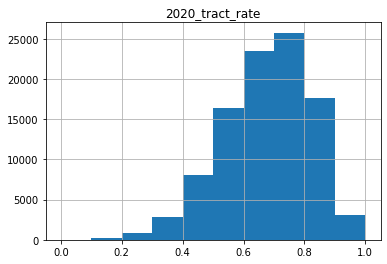

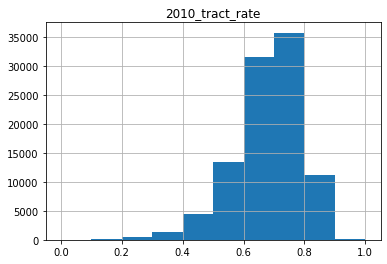

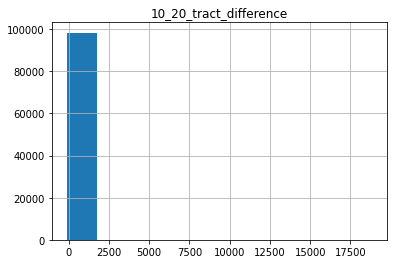

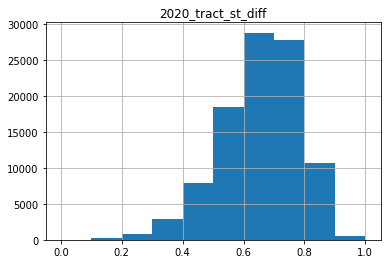

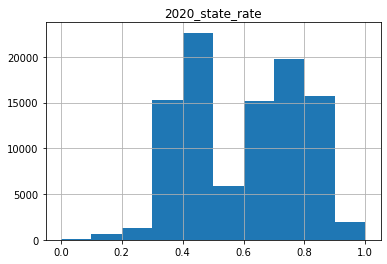

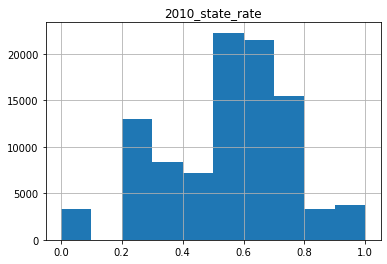

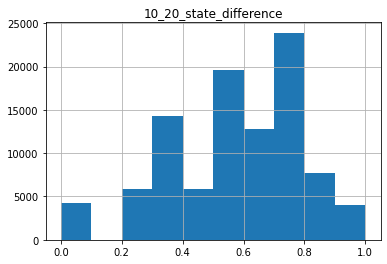

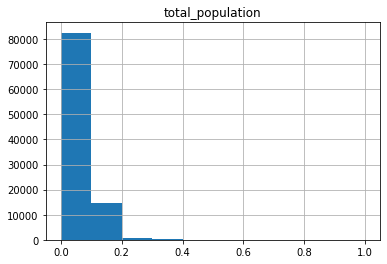

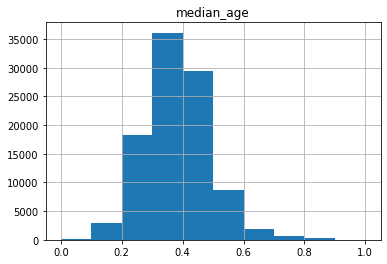

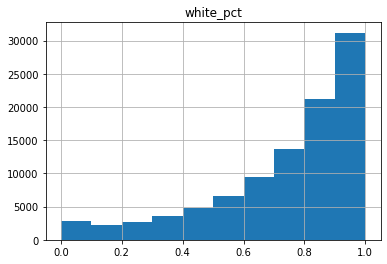

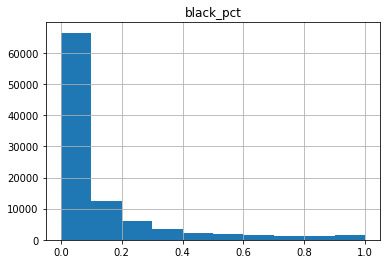

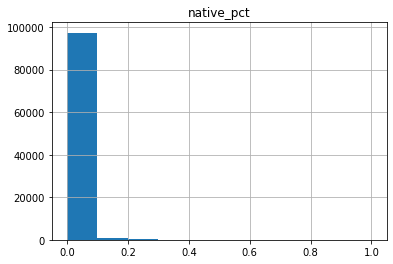

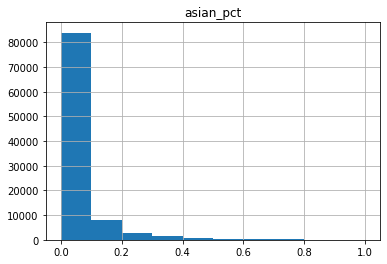

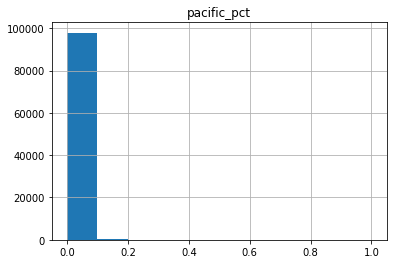

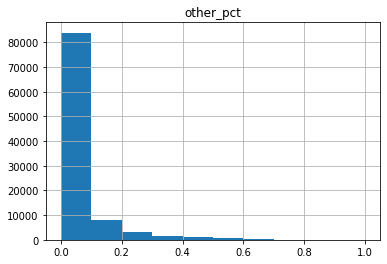

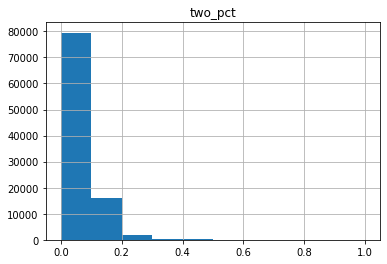

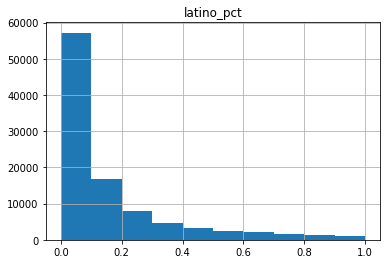

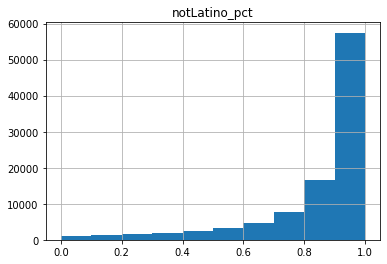

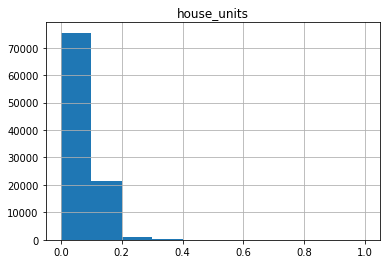

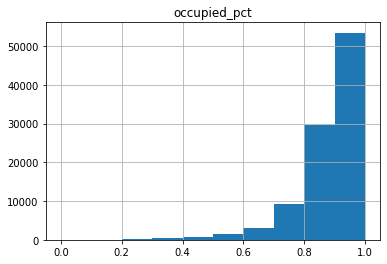

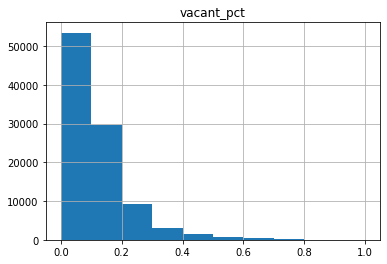

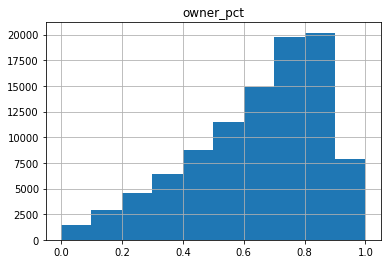

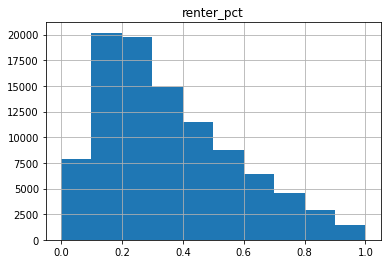

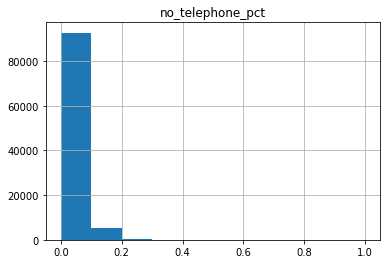

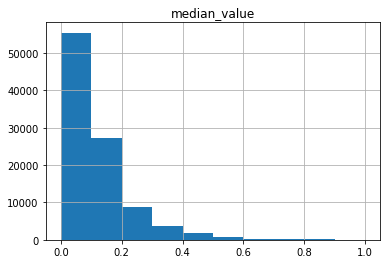

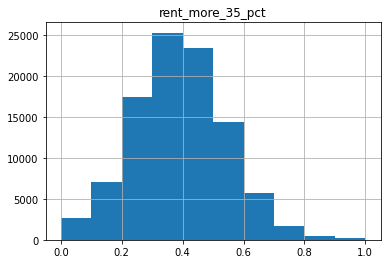

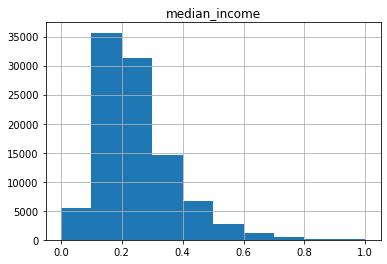

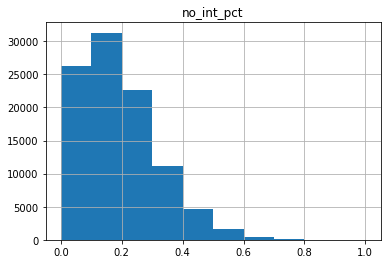

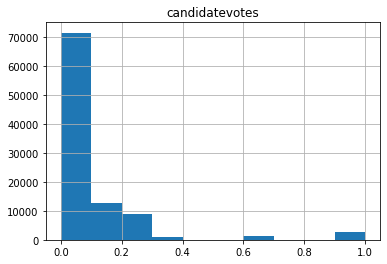

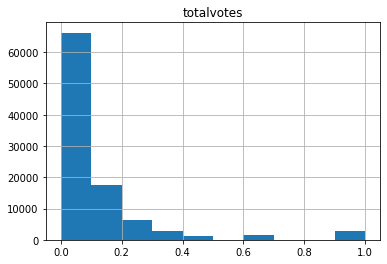

In [138]:
nprNorm = dfNorm[dfNorm.State != 'Puerto Rico']

for i in nprNorm.columns:
  display(nprNorm[[i]].hist())

#### 2020 regressions

In [139]:
### 2020 Multi-regression

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
X = nprNorm[['2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct',
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = nprNorm[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(y, X).fit().summary())

                                   OLS Regression Results                                  
Dep. Variable:     10_20_tract_difference   R-squared (uncentered):                   0.029
Model:                                OLS   Adj. R-squared (uncentered):              0.029
Method:                     Least Squares   F-statistic:                              129.6
Date:                    Tue, 11 Aug 2020   Prob (F-statistic):                        0.00
Time:                            15:20:32   Log-Likelihood:                     -5.4808e+05
No. Observations:                   98303   AIC:                                  1.096e+06
Df Residuals:                       98280   BIC:                                  1.096e+06
Df Model:                              23                                                  
Covariance Type:                nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.

In [140]:
### 2020 linear regressions for each variable
pd.set_option('display.max_columns', None)
temp = nprNorm[["10_20_tract_difference", '2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
 'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
  
    X = temp[col]
    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9445      1.291      2.281      0.023       0.414       5.475
2010_tract_rate   -13.6234      1.875     -7.264      0.000     -17.299      -9.948
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -10.1036      0.593    -17.033      0.000     -11.266      -8.941
2010_state_rate     6.8912      1.012      6.812      0.000       4.908       8.874
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.3925      0.401    -23.409      0.000     -10.179      -8.606
total_population    43.8146      4.903      8.937      0.000      34.205 

In [ ]:
### 2020 edited multi-regressions
#Edited = Run regressions with fewer variables

#put all variables for predicting 2020 rates in dataframe
X = nprNorm[['white_pct', 'black_pct', 'native_pct', 'asian_pct', 
                      'latino_pct', 'vacant_pct', 'renter_pct', 
                      'no_telephone_pct', 'median_value', 'rent_more_35_pct',
                      'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = nprNorm[["2020_tract_rate"]]

#build and fit the multi-regression model
print(sm.OLS(y, X).fit().summary())

#### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
X = nprNorm[['total_population', 'median_age', 'white_pct', 
                     'black_pct', 'native_pct', 'asian_pct', 'pacific_pct',
                     'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct',
                     'house_units', 'occupied_pct', 'vacant_pct', 'renter_pct',
                     'no_telephone_pct', 'median_value', 'rent_more_35_pct',
                     'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
y = nprNorm[["2010_tract_rate"]]

#create model and print summary table
#print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2010 linear regression for each variable

temp = nprNorm[['2010_tract_rate','total_population', 'median_age', 'white_pct', 
              'black_pct', 'native_pct',  'asian_pct','pacific_pct','other_pct',
              'two_pct', 'latino_pct',  'notLatino_pct', 'house_units', 
              'occupied_pct', 'vacant_pct', 'owner_pct',  'renter_pct', 
              'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
              'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '2010_tract_rate']:
    Y = temp['2010_tract_rate']
    
    X = temp[col]
    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

### Puerto Rico

In [141]:
#create df with just puerto rico
pr = df[df['State'] == 'Puerto Rico']

In [145]:
pr.tocsv('/content/drive/Shared drives/Shared Items/census-responses/data/puerto_rico.csv')

#### 2020 regressions

In [ ]:
### 2020 Multi-regression

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
X = pr[['2010_tract_rate', 'total_population', 'median_age', 
                  'white_pct', 'black_pct', 'native_pct', 'asian_pct',
                  'pacific_pct', 'other_pct', 'two_pct', 'latino_pct',  
                  'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct',
                  'owner_pct','renter_pct', 'no_telephone_pct', 'median_value',
                  'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = pr[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2020 linear regressions for each variable

temp = pr[['10_20_tract_difference', 'white_pct', 'black_pct', 'native_pct', 
              'asian_pct', 'latino_pct', 'vacant_pct', 'renter_pct', 
              'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
              'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
    
    X = temp[col]
    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

In [ ]:
### 2020 edited linear regressions
# Edited = Run regressions with fewer variables

temp = pr[["10_20_tract_difference", 'white_pct', 'black_pct', 'native_pct', 
              'asian_pct','pacific_pct','latino_pct', 'vacant_pct','renter_pct',
              'no_telephone_pct','median_value','rent_more_35_pct',
              'median_income','no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
   
    X = temp[col]
    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

#### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
X = pr[['total_population', 'median_age',
                  'white_pct', 'black_pct', 'native_pct', 'asian_pct',
                  'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
                  'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct',
                  'owner_pct','renter_pct', 'no_telephone_pct', 'median_value',
                  'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
y = pr[["2010_tract_rate"]]

#create model and print summary table
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2010 linear regression for each variable

temp = pr[['2010_tract_rate','total_population', 'median_age','white_pct', 
           'black_pct', 'native_pct', 'asian_pct', 'pacific_pct', 'other_pct', 
           'two_pct','latino_pct','notLatino_pct','house_units', 'occupied_pct', 
           'vacant_pct', 'owner_pct','renter_pct', 'no_telephone_pct', 
           'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '2010_tract_rate']:
    Y = temp['2010_tract_rate']
    
    X = temp[col]
    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

# Scrap Code

## Analysis with Puerto Rico

### 2010-2020 Changes

In [59]:
display(states.sort_values(by='10_20_state_difference'))

,GEO_ID,State,Region,2020_state_rate,2010_state_rate,2000_state_rate,10_20_state_difference
51,0400000US72,Puerto Rico,Puerto Rico,28.8,54.0,54.0,-46.666667
40,0400000US45,South Carolina,South,57.5,75.0,68.0,-23.333333
1,0400000US02,Alaska,West,50.0,64.0,67.0,-21.875000
33,0400000US37,North Carolina,South,59.4,76.0,69.0,-21.842105
9,0400000US12,Florida,South,60.2,74.0,71.0,-18.648649
19,0400000US23,Maine,Northeast,55.6,68.0,67.0,-18.235294
10,0400000US13,Georgia,South,59.0,72.0,72.0,-18.055556
43,0400000US48,Texas,South,58.3,71.0,70.0,-17.887324
31,0400000US35,New Mexico,West,53.5,65.0,68.0,-17.692308
42,0400000US47,Tennessee,South,62.6,76.0,72.0,-17.631579


In [58]:
display(states.sort_values(by='2020_state_rate'))

,GEO_ID,State,Region,2020_state_rate,2010_state_rate,2000_state_rate,10_20_state_difference
51,0400000US72,Puerto Rico,Puerto Rico,28.8,54.0,54.0,-46.666667
1,0400000US02,Alaska,West,50.0,64.0,67.0,-21.875000
31,0400000US35,New Mexico,West,53.5,65.0,68.0,-17.692308
48,0400000US54,West Virginia,South,54.9,65.0,68.0,-15.538462
19,0400000US23,Maine,Northeast,55.6,68.0,67.0,-18.235294
45,0400000US50,Vermont,Northeast,56.9,69.0,68.0,-17.536232
26,0400000US30,Montana,West,56.9,68.0,72.0,-16.323529
18,0400000US22,Louisiana,South,57.4,65.0,68.0,-11.692308
40,0400000US45,South Carolina,South,57.5,75.0,68.0,-23.333333
50,0400000US56,Wyoming,West,57.6,69.0,75.0,-16.521739


In [ ]:
temp = df[df['State']=='Puerto Rico'].sort_values(by='2020_tract_rate', ascending=False)

print("# Puerto Rico Tracts with 2020 response rate greater than 2010:",
      len(temp[temp['2020_tract_rate'] >= temp['2010_tract_rate']]), 
      "\n\n", temp[temp['2020_tract_rate'] >= temp['2010_tract_rate']].sort_values(by='2020_tract_rate', ascending=False))


In [60]:
#how many tracts have lower response rate than in 2010
lower = df.loc[(df['2020_tract_rate'] < df['2010_tract_rate']
            ) & (df['10_20_tract_difference'] != -1)].sort_values(
        by='10_20_tract_difference', ascending=True)
            
#see what percent of state tracts have lower response
temp = pd.merge(pd.DataFrame(lower['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_lower'}),
    pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
    on=['state'])

temp['lower_percent'] = (temp['count_lower']*100) / temp['count']

print(
    "Total lower tracts:", sum(temp['count_lower']),
    '\nLowers as % of all tracts:', 
    (sum(temp['count_lower'])*100) / sum(temp['count']), "\n",
    len(lower), "of", len(df), "total tracts, or", len(lower)*100/len(df), "% have lower \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="lower_percent"), "\n\n",)

Total lower tracts: 74947 
Lowers as % of all tracts: 72.38458566737492 
 74947 of 103540 total tracts, or 72.38458566737492 % have lower 
response rates in 2020 than 2010
 
                    state  count_lower  count  lower_percent
31            Washington          918   2404      38.186356
45                 Idaho          245    567      43.209877
49         New Hampshire          192    409      46.943765
14              Michigan         1569   3340      46.976048
38                Nevada          452    890      50.786517
36                  Utah          530    991      53.481332
24               Arizona         1148   2079      55.218855
29              Colorado          968   1732      55.889145
33                Oregon          741   1309      56.608098
28              Kentucky          970   1585      61.198738
19             Minnesota         1235   2015      61.290323
12              Virginia         1573   2510      62.669323
23         Massachusetts         1186   1867 

In [ ]:
#tracts with 2020 response rate > 2010
higher = df.loc[(df['2020_tract_rate'] > df['2010_tract_rate']
            ) & (df['2010_tract_rate'] != 0)].sort_values(
        by='10_20_tract_difference', ascending=True)
            
temp = pd.merge(pd.DataFrame(higher['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_higher'}),
                pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                on=['state'])

temp['higher_percent'] = (temp['count_higher']*100) / temp['count']

print(
    "Total higher tracts:", sum(temp['count_higher']),
    '\nHighers as % of all tracts:', 
    (sum(temp['count_higher'])*100) / sum(temp['count']), "\n",
    len(higher), "of", len(df), "total tracts, or", len(higher)*100/len(df), 
    "% have higher \nresponse rates in 2020 than 2010\n\n",
    temp.sort_values(by="higher_percent"), "\n\n")

In [ ]:
# some stats on tracts with lower and higher rates
display(lower.describe())
display(df.describe())
display(higher.describe())
print('Higher rates vote:\n', higher.party.value_counts(),
      '\n\nDf rates vote:\n', df.party.value_counts(),
      '\n\nLower rates vote:\n', lower.party.value_counts())

In [46]:
#lowest tract rates
lowest = df.sort_values(by='2020_tract_rate').head(1000)
print("1000 lowest tracts comprise", len(lowest) *100 / len(df), "off all tracts")
display(lowest.Region.value_counts(),
        lowest.describe(),
        df.describe())

1000 lowest tracts comprise 0.9658103148541627 off all tracts


West           349
South          252
Puerto Rico    225
Northeast      115
Midwest         59
Name: Region, dtype: int64

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct,FIPS,candidatevotes,totalvotes
count,1000.000000,841.000000,832.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,968.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,1000.000000,971.000000,971.00000,960.000000,960.000000,958.000000,8.480000e+02,932.000000,914.000000,960.000000,761.000000,7.610000e+02,7.610000e+02
mean,15.556300,37.148751,inf,-38.430500,53.986800,67.885000,-21.962090,3156.714000,41.296901,66.670709,8.436074,10.728983,2.242035,0.169168,8.403083,3.346660,34.868243,65.131757,2181.333000,57.811843,42.18826,60.186146,39.814063,4.444572,2.219939e+05,42.447210,43115.349015,29.295346,26528.939553,1.880923e+05,2.935346e+05
std,5.374771,18.866900,NaN,16.165837,14.145655,8.204821,13.723196,2274.722872,12.574965,30.606665,14.700019,27.832485,5.751614,0.998865,14.740165,4.692427,39.761001,39.761001,1927.821933,25.395636,25.39549,27.139097,27.139222,6.111776,2.290202e+05,21.246374,27186.104567,21.392454,17053.127568,4.792100e+05,6.840924e+05
min,0.000000,0.000000,-100.000000,-69.000000,28.800000,54.000000,-46.666667,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.940000e+04,0.000000,3050.000000,0.000000,1003.000000,5.800000e+01,6.500000e+01
25%,12.900000,23.700000,-64.782000,-49.000000,53.500000,65.000000,-21.875000,1534.250000,31.825000,49.200000,0.100000,0.000000,0.000000,0.000000,0.100000,0.600000,3.300000,13.700000,949.750000,37.550000,21.50000,46.550000,19.875000,1.100000,8.617500e+04,28.575000,21136.500000,10.826449,6107.000000,9.592000e+03,1.617400e+04
50%,17.300000,38.800000,-55.113939,-42.800000,59.400000,71.000000,-16.323529,2672.500000,41.400000,76.000000,1.700000,0.200000,0.400000,0.000000,1.800000,2.000000,12.200000,87.800000,1719.000000,63.100000,36.90000,68.300000,31.700000,2.750000,1.347000e+05,41.700000,39542.000000,25.594757,32001.000000,3.240400e+04,5.713500e+04
75%,19.700000,48.800000,-29.626403,-34.000000,64.700000,74.000000,-12.820513,4438.750000,50.000000,93.000000,10.800000,1.800000,1.800000,0.000000,9.000000,4.400000,86.300000,96.700000,2943.000000,78.500000,62.45000,80.125000,53.450000,5.500000,2.756250e+05,54.825000,57859.500000,43.413634,40091.000000,1.212500e+05,2.015510e+05
max,21.800000,100.000000,inf,-7.000000,72.500000,82.000000,-7.500000,18703.000000,74.000000,100.000000,100.000000,100.000000,59.900000,25.300000,100.000000,66.700000,100.000000,100.000000,15527.000000,100.000000,100.00000,100.000000,100.000000,63.400000,1.923100e+06,100.000000,237639.000000,100.000000,55125.000000,2.464364e+06,3.434308e+06


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct,FIPS,candidatevotes,totalvotes
count,103540.000000,102847.000000,1.028380e+05,103540.000000,103540.000000,103540.000000,103540.000000,103540.000000,103321.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103540.000000,103294.000000,103294.000000,103270.000000,103270.000000,102398.000000,1.015520e+05,103123.000000,102963.000000,103270.000000,102048.000000,1.020230e+05,1.020480e+05
mean,62.681958,67.690365,inf,-0.311211,62.993169,73.618041,-14.567829,4949.205833,39.463309,73.245816,13.083205,0.889803,4.900626,0.170504,4.527902,3.181698,17.133094,82.866948,2087.127487,87.810794,12.189295,63.984057,36.016050,2.266941,2.521893e+05,39.182103,64252.382565,17.074833,27781.561912,2.543681e+05,4.000174e+05
std,14.493412,11.313510,NaN,13.335866,5.743637,4.247514,4.823143,2963.114947,7.819423,24.336115,20.767391,4.403487,9.112682,1.097695,8.458077,3.116841,22.717655,22.717659,1146.099229,10.974492,10.974486,22.449101,22.449104,2.280203,2.144128e+05,15.467814,31698.656049,11.583500,16033.544848,4.530160e+05,6.465683e+05
min,0.000000,0.000000,-1.000000e+02,-69.000000,28.800000,54.000000,-46.666667,0.000000,5.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,0.000000,3025.000000,0.000000,1001.000000,5.800000e+01,0.000000e+00
25%,53.600000,61.700000,-1.399358e+01,-8.200000,59.100000,71.000000,-17.631579,3119.000000,34.200000,61.700000,1.000000,0.000000,0.300000,0.000000,0.200000,1.200000,2.800000,79.100000,1360.000000,84.400000,5.100000,50.200000,18.500000,0.800000,1.172000e+05,29.000000,42359.500000,8.201893,12115.000000,2.729400e+04,4.456000e+04
50%,64.400000,69.200000,-5.792094e+00,1.200000,64.700000,74.000000,-13.896104,4450.000000,39.100000,81.300000,4.200000,0.100000,1.600000,0.000000,1.300000,2.400000,7.600000,92.400000,1898.000000,90.800000,9.200000,69.100000,30.900000,1.800000,1.817000e+05,38.900000,57348.000000,15.015480,27117.000000,1.019440e+05,1.783120e+05
75%,73.600000,75.500000,4.278076e-01,9.400000,67.500000,76.000000,-11.447368,6132.000000,44.200000,92.100000,14.700000,0.600000,5.200000,0.000000,4.700000,4.300000,20.900000,97.200000,2594.000000,94.900000,15.600000,81.500000,49.800000,3.100000,3.110000e+05,49.100000,78846.000000,23.436323,41071.000000,2.970510e+05,4.402470e+05
max,98.100000,100.000000,inf,39.100000,72.500000,82.000000,-7.500000,70271.000000,84.500000,100.000000,100.000000,100.000000,93.400000,76.200000,100.000000,66.700000,100.000000,100.000000,26436.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.995100e+06,100.000000,250000.000000,100.000000,56045.000000,2.464364e+06,3.434308e+06


In [55]:
# get info on 1000 tracks with greatest drop in response rate
big_drop = df.loc[(
    df['10_20_tract_difference'] > -100) & (
    df['10_20_tract_difference'] < 0)].sort_values(
                  by='10_20_tract_difference', ascending=True).head(1000)
  
temp = pd.merge(pd.DataFrame(big_drop.Region.head(1000).value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_drop'}),
    pd.DataFrame(df.Region.value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_all'}),
        on=['Region'])
temp['pct_drop']= temp.count_drop * 100 / temp.count_all

print("By region:\n", temp,
      "\n\nBy state:\n", big_drop.State.value_counts())

By region:
         Region  count_drop  count_all   pct_drop
0  Puerto Rico         552       1227  44.987775
1         West         167      23420   0.713066
2        South         154      38821   0.396693
3    Northeast          81      16759   0.483322
4      Midwest          46      23313   0.197315 

By state:
 Puerto Rico       552
California         68
Texas              65
New York           43
New Mexico         27
Arizona            21
Florida            17
North Carolina     13
Pennsylvania       13
South Carolina     13
Missouri           11
Massachusetts      11
West Virginia      11
Oregon              9
Wisconsin           9
Nevada              9
Alaska              9
Montana             8
Michigan            7
North Dakota        6
Ohio                6
Mississippi         6
Utah                6
Hawaii              5
Louisiana           5
Maryland            5
New Jersey          4
Connecticut         4
Georgia             4
Illinois            3
Oklahoma            3

In [57]:
# temp with tracts less than half 2010 rate
temp = df.loc[(df['10_20_tract_difference'] > -100) & (df['10_20_tract_difference'] <= -50)]

temp1 = pd.merge(pd.DataFrame(temp.Region.value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_half'}),
    pd.DataFrame(df.Region.value_counts()).reset_index().rename(columns={'index':'Region', 'Region':'count_all'}),
        on=['Region'])
temp1['pct_half']= temp1.count_half * 100 / temp1.count_all

print(len(temp), "or", len(temp) / len(df) * 100,
      "% of tracts have a 2020 response rate \n half or less than half their 2010 rate\n\n",
      "\n\nBy region:\n", temp1,
      "\n\nBy state:\n", temp.State.value_counts())

1176 or 1.1357929302684953 % of tracts have a 2020 response rate 
 half or less than half their 2010 rate

 

By region:
         Region  count_half  count_all   pct_half
0  Puerto Rico         660       1227  53.789731
1         West         195      23420   0.832622
2        South         180      38821   0.463667
3    Northeast          88      16759   0.525091
4      Midwest          53      23313   0.227341 

By state:
 Puerto Rico       660
California         80
Texas              76
New York           46
New Mexico         27
Arizona            25
Florida            19
Pennsylvania       16
South Carolina     15
Missouri           13
West Virginia      13
Nevada             13
North Carolina     13
Michigan           11
Massachusetts      11
Oregon             10
Alaska             10
Montana            10
Wisconsin           9
Georgia             8
Ohio                7
North Dakota        6
Mississippi         6
Oklahoma            6
Louisiana           6
Utah                6

In [ ]:
# biggest increases in response rates
# get info on 1000 tracks with greatest gain in response rate
big_gain = df.loc[(df['10_20_tract_difference'] > 0) & (
    df['2010_tract_rate'] != 0)].sort_values(
                  by='10_20_tract_difference', ascending=False).head(1000)
print("By region:\n", big_gain.Region.value_counts(),
      "\n\nBy state:\n", big_gain.State.value_counts())

In [ ]:
# some stats on biggest gains and drops
display(big_gain.describe().round(1))
display(df.describe().round(1))
display(big_drop.describe().round(1))

In [ ]:
#info on drops and gains by party
print('Gains vote:\n', big_gain.party.value_counts(),
      '\n\nDf vote:\n', df.party.value_counts(),
      '\n\nDrops vote:\n', big_drop.party.value_counts(), "\n\n")
display(big_gain.groupby('party').describe())
display(df.groupby('party').describe())
display(big_drop.groupby('party').describe().T)

In [ ]:
# how many tracts have 2020 rate double their 2010 rate
print(len(big_gain[big_gain['10_20_tract_difference'] >= 1]) * 100 / len(df),
      "% of tracts have a 2020 response rate at least double their 2010 rate")

In [ ]:
#ensure higher and lower contain data except for inf, 0, na 10_20_difference
temp=df.drop(lower.index).drop(higher.index)

print(len(df), "\n",
      len(higher), "\n",
      len(lower), "\n",
      len(temp), "\n",
      len(higher) + len(lower) + len(temp), "\n",
      "0 change:", len(temp[temp['10_20_tract_difference'] == 0]), "\n\n",
      temp['10_20_tract_difference'].value_counts())

### Graphs

In [ ]:
## latino vs tract change

# make a graph yay
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook

x = df.latino_pct
y = df['10_20_tract_difference'] / 100

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Latino Compared to Tract Response Rate Change') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_vs_change.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
x = df.black_pct
y = df['10_20_tract_difference']

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Black') 
# naming the y axis 
plt.ylabel('Response Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Black Compared to Tract Response Rate Change') 

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_vs_change.png',
#            bbox_inches='tight')

# function to show the plot 
plt.show() 


### Race / Ethnicity

In [ ]:
# show all tracts where Latino population 95% or higher by state
display(df[df.latino_pct >= 95].State.value_counts())

# show all 95 or higher Latino tracts in Texas
display(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)])

In [ ]:
# compare high percentage Latino tracts to total # tracts in county

temp = pd.merge(pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'maj_Latino'}),
                 pd.DataFrame(df.loc[(df.State == 'Texas')].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'total'}),
                 how='left')

#calculate what % all tracts is 95% or more Latino in Texas
temp['maj_Latino_pct'] = (temp['maj_Latino']*100) / temp['total']

print(
    "Total majority latino tracts in Texas:", sum(temp['maj_Latino']),
    '\nMajority Latino as % of all Texas tracts:', (sum(temp['maj_Latino'])*100) / sum(temp['total']),
    "\n\n",temp)

In [ ]:
display(
    "maj Latino",
    pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)]).loc[(
        (pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)])).groupby(
        'county')['county'].transform('size') > 10)].groupby(by='county').describe(),
    'all Texas',
    pd.DataFrame(df.loc[(df.State == 'Texas')]).groupby(by='county').describe())

In [ ]:
# temp dataframe with mean instead of NA or inf
temp = df.replace([np.inf, -np.inf], np.nan).fillna(df.mean())
print(min(temp['10_20_tract_difference']), max(temp['10_20_tract_difference']))

In [ ]:
display("0%", temp.loc[(temp.asian_pct == 0)].describe(),
"5%",temp.loc[(temp.asian_pct <= 5)].describe(),
"25%",temp.loc[(temp.asian_pct >= 25)].describe(),
"33%",temp.loc[(temp.asian_pct >= 33)].describe(),
"50%",temp.loc[(temp.asian_pct >= 50)].describe(),
"66%",temp.loc[(temp.asian_pct >= 66)].describe(),
"75%",temp.loc[(temp.asian_pct >= 75)].describe(),
"85%",temp.loc[(temp.asian_pct >= 85)].describe(),
df.describe())

In [ ]:
display(df.describe(),
        "0%", temp.loc[(temp.black_pct == 0)].describe(),
"5%",temp.loc[(temp.black_pct <= 5)].describe(),
"25%",temp.loc[(temp.black_pct >= 25)].describe(),
"33%",temp.loc[(temp.black_pct >= 33)].describe(),
"50%",temp.loc[(temp.black_pct >= 50)].describe(),
"66%",temp.loc[(temp.black_pct >= 66)].describe(),
"75%",temp.loc[(temp.black_pct >= 75)].describe(),
"90%",temp.loc[(temp.black_pct >= 90)].describe(),
"95%",temp.loc[(temp.black_pct >= 95)].describe())

In [ ]:
display("0%", temp.loc[(temp.white_pct == 0)].describe(),
"5%",temp.loc[(temp.white_pct <= 5)].describe(),
"25%",temp.loc[(temp.white_pct >= 25)].describe(),
"33%",temp.loc[(temp.white_pct >= 33)].describe(),
"50%",temp.loc[(temp.white_pct >= 50)].describe(),
"66%",temp.loc[(temp.white_pct >= 66)].describe(),
"75%",temp.loc[(temp.white_pct >= 75)].describe())

In [ ]:
display("0%", temp.loc[(temp.native_pct == 0)].describe(),
"5%",temp.loc[(temp.native_pct <= 5)].describe(),
"25%",temp.loc[(temp.native_pct >= 25)].describe(),
"33%",temp.loc[(temp.native_pct >= 33)].describe(),
"50%",temp.loc[(temp.native_pct >= 50)].describe(),
"66%",temp.loc[(temp.native_pct >= 66)].describe(),
"75%",temp.loc[(temp.native_pct >= 75)].describe())

In [ ]:
display("0%", temp.loc[(temp.latino_pct == 0)].describe(),
"5%",temp.loc[(temp.latino_pct <= 5)].describe(),
"25%",temp.loc[(temp.latino_pct >= 25)].describe(),
"33%",temp.loc[(temp.latino_pct >= 33)].describe(),
"50%",temp.loc[(temp.latino_pct >= 50)].describe(),
"66%",temp.loc[(temp.latino_pct >= 66)].describe(),
"75%",temp.loc[(temp.latino_pct >= 75)].describe())

### National Comparative Rankings 2010 vs 2020

In [ ]:
# average difference by region
states.groupby('Region').mean().sort_values(by='10_20_state_difference', ascending=False)

In [ ]:
#assign ranks to states based on comparative response rate
states['2020_rank'] = states['2020_state_rate'].rank(method='max', ascending=False)
states['2010_rank'] = states['2010_state_rate'].rank(method='max', ascending=False)

#pull ranks into separate dataframe
state_ranks = states[['State', '2020_rank', '2010_rank']].sort_values(by='2020_rank')

#show change in rank from 2010 to 2020
#negative number means a state has a lower 2020 response rate and has gone down in rankings
state_ranks['rank_change'] = state_ranks['2010_rank'] - state_ranks['2020_rank']
#state_ranks.sort_values(by='rank_change', ascending=True)

#see how many states only changed 2 or fewer positions
#small_change = state_ranks[state_ranks.rank_change.between(-2, 2, inclusive=True)].sort_values(by='rank_change')
#small_change
#16 states have stayed ~similar in the rankings, and this seems to impact
#states with both high and low response rates
#small_change.mean(axis=0)['2020_rank']

### Internet Usage

Internet usage is only available for 2020 rates

In [ ]:
### Percent of response rate not from internet

print(
    "The average state response rate to the census NOT conducted online:",
    states2020.mean(axis=0)['state_not_int_pct'])

# average non internet response rate
states2020.groupby(by='State').mean().sort_values(
    by='state_not_int_pct', ascending=False).merge(state_ranks, on='State')

In [ ]:
### Without Puerto Rico

#make non-pr df
npr = states2020[states2020['State'] != 'Puerto Rico']

# average internet response
npr.mean(axis=0)['state_internet']

In [ ]:
# average overall response rate
npr.mean(axis=0)['2020_state_rate']

### Region Analysis

In [ ]:
# average by region
# NOTE as tribal tracts are not assigned to a state they do not have a corresponding region and thus are not counted in the regional calculations
states.groupby('Region').mean().sort_values(by='2020_state_rate', ascending=False)

In [ ]:
# average difference as of 6/15/20
#this can take a while to run so is commented out unless needed
#tracts.mean(axis=0)['10_20_tract_difference']

In [ ]:
# average difference by region
tracts.groupby('Region').mean().sort_values(by='10_20_tract_difference', ascending=False)

In [ ]:
#tract average differences vs state rates
tracts.groupby('State').mean().sort_values(by='2020_state_rate', ascending=False)

### Tribal tracts

In [ ]:
# create df with response rates in tribal tracts
tribal = tracts2020[tracts2020['Geo_Type'].str.contains("Tribal")].sort_values(
    by='2020_tract_rate', ascending=False)

In [ ]:
### tribal areas and tracts stats

#mean non internet response
print("Average % non-int response tribal:", 
      tribal.mean(axis=0)['tract_not_int_pct'], "%")

In [ ]:
# mean overall response rate
print("Tribal average response rate:",
      tribal.mean(axis=0)['2020_tract_rate'], "%")

### Tracts with 0 overall response rate

In [ ]:
## Tracts with 0 cumulative response rate
zeros = df[df['2020_tract_rate'] == 0]

print("Number of tracts with 0 cumulative response rate:", len(zeros), "\n")

#return data frame with each tract with 0 2020 response rate
zeros.sort_values(by='State')

In [ ]:
#make dataframe of states with # tracts with 0%, number total tracts,
#and what % of total tracts are 0
temp = pd.merge(pd.DataFrame(zeros['State'].value_counts()),
                pd.DataFrame(tracts['State'].value_counts()),
                right_index=True, left_index=True).rename(
                    columns={"State_x": "0_tracts", "State_y" : "total_tracts"})
#compute percentage
temp['0_percent'] = temp['0_tracts'] * 100 / temp['total_tracts']
temp

## Regressions With Puerto Rico

### 2020 Regressions

In [ ]:
### 2020 Multi-regression

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
variables20 = reg_df[['2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct',
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
target20 = reg_df[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(target20, variables20).fit().summary())

In [ ]:
### 2020 linear regressions for each variable

from sklearn import linear_model

#create list of variable names
cols = variables20.columns.tolist()
#build linear model
regr = linear_model.LinearRegression()
#create empty list to store loop results
rows = []
#loop through each variable
for i in cols:
    #fit linear model to variable
    regr.fit(variables20[[i]], target20)
    #save model variable name, intercept, coef and r^2 to list
    rows.append([i, regr.intercept_, regr.coef_, regr.score(variables20[[i]], target20)])

#turn list into df with these column names
linears20 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets lol
linears20['coefficient'] = linears20['coefficient'].str.get(0)
linears20['coefficient'] = linears20['coefficient'].str.get(0)
linears20['intercept'] = linears20['intercept'].str.get(0)

#print df sorted coefs largest --> smallest
linears20.sort_values(by='coefficient', ascending=False)

### Normalized 2020 inputs

In [ ]:
### 2020 Multi regression with normalized variables

#normalize variable values
norm_variables20 = (variables20 - variables20.min()) / (variables20.max() - variables20.min())

#build normalized multi-regress model and print summary
print(sm.OLS(target20, norm_variables20).fit().summary())

In [ ]:
#2020 normalized linear regressions for each variable

# linear regression for each variable 'i'
cols = norm_variables20.columns.tolist()
# create model
norm_regr = linear_model.LinearRegression()
#empty list for loop results
rows = []
#loop through each variable
for i in cols:
    #fit model to each variable
    norm_regr.fit(norm_variables20[[i]], target20)
    #add model results to list
    rows.append([i, norm_regr.intercept_, norm_regr.coef_, 
                 norm_regr.score(norm_variables20[[i]], target20)])

#turn list into dataframe
norm_linears20 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
norm_linears20['coefficient'] = norm_linears20['coefficient'].str.get(0)
norm_linears20['coefficient'] = norm_linears20['coefficient'].str.get(0)
norm_linears20['intercept'] = norm_linears20['intercept'].str.get(0)

#print df ordered by largest to smallest coef
norm_linears20.sort_values(by='coefficient', ascending=False)

### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
variables10 = reg_df[['total_population', 'median_age', 'white_pct', 
                      'black_pct', 'native_pct','asian_pct', 'pacific_pct', 
                      'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct', 
                      'house_units', 'occupied_pct', 'vacant_pct', 'renter_pct', 
                      'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
                      'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
target10 = reg_df[["2010_tract_rate"]]

#create model and print summary table
print(sm.OLS(target10, variables10).fit().summary())

In [ ]:
### 2010 linear regression for each variable

#list of variable names
cols = variables10.columns.tolist()
#build multi-reg model
regr = linear_model.LinearRegression()
#create empty list for loop results
rows = []

#loop through variables
for i in cols:
    #fit a model to the current variable
    regr.fit(variables10[[i]], target10)
    #save the model's resulting variable name, intercept, coef, and r^2
    rows.append([i, regr.intercept_, regr.coef_,
                regr.score(variables10[[i]], target10)])

#turn list into data frame
linears10 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
linears10['coefficient'] = linears10['coefficient'].str.get(0)
linears10['coefficient'] = linears10['coefficient'].str.get(0)
linears10['intercept'] = linears10['intercept'].str.get(0)

#print data frame ordered coefficient largest --> smallest
linears10.sort_values(by='coefficient', ascending=False)

### Normalized 2010 Regressions

In [ ]:
### 2010 normalized multi-regression

#normalize the variables
norm_variables10 = (variables10 - variables10.min()) / (variables10.max() - variables10.min())

#build normalized model and print summary
print(sm.OLS(target10, norm_variables10).fit().summary())

In [ ]:
###2010 normalized linear regressions for each variable

#create list of variable names
cols = norm_variables10.columns.tolist()
#build the model
norm_regr = linear_model.LinearRegression()
#create empty list for model results
rows = []
#cycle through variables
for i in cols:
    #do the linear regression on the current variable
    norm_regr.fit(norm_variables10[[i]], target10)
    #add the corresponding variable name, intercept, coefficient and r-squared to the list
    rows.append([i, norm_regr.intercept_, norm_regr.coef_,
                norm_regr.score(norm_variables10[[i]], target10)])

#turn list into data frame with these column names
norm_linears10 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
norm_linears10['coefficient'] = norm_linears10['coefficient'].str.get(0)
norm_linears10['coefficient'] = norm_linears10['coefficient'].str.get(0)
norm_linears10['intercept'] = norm_linears10['intercept'].str.get(0)

#print df sorted by coefficient
norm_linears10.sort_values(by='coefficient', ascending=False)

### 2020 Edited Regressions
Edited = Run regressions with fewer variables

In [ ]:
### 2020 edited multi-regressions

#put all variables for predicting 2020 rates in dataframe
variables_ed = reg_df[['white_pct', 'black_pct', 'native_pct', 
 'latino_pct','vacant_pct', 'renter_pct', 
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
target_ed = reg_df[["2020_tract_rate"]]

#build and fit the multi-regression model
print(sm.OLS(target_ed, variables_ed).fit().summary())

In [ ]:
### 2020 edited linear regressions

#create list of variable names
cols = variables_ed.columns.tolist()
#build the model
regr = linear_model.LinearRegression()
#create empty list to append results
rows = []

#loop through variables
for i in cols:
    #fit the model
    regr.fit(variables_ed[[i]], target_ed)
    #put model variable name, intercept, coef and r^2 in list
    rows.append([i, regr.intercept_, regr.coef_,
                regr.score(variables_ed[[i]], target_ed)])

#turn list into data frame with these column names
linears_ed = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
linears_ed['coefficient'] = linears_ed['coefficient'].str.get(0)
linears_ed['coefficient'] = linears_ed['coefficient'].str.get(0)
linears_ed['intercept'] = linears_ed['intercept'].str.get(0)

#print df sorted by coefficient largest --> smallest
linears_ed.sort_values(by='coefficient', ascending=False)

In [ ]:
### normalized 2020 edited variables multi regression

#normalize the variables
norm_variables_ed = (variables_ed - variables_ed.min()) / (variables_ed.max() - variables_ed.min())

#build normalized model and print summary
print(sm.OLS(target_ed, norm_variables_ed).fit().summary())

In [ ]:
##see all dfs in memory
%whos DataFrame

#### Existing DFs:

# df: dataframe with all years, states, tracts, demographics

# states: 2010 and 2020 state rates
# states2010: 2010 State rates
# states2020: 2020 State rates

# tracts: 2010 and 2020 tract and state rates
# tracts2010: 2010 tract rates
# tracts2020: 2020 tract rates

# all20: 2020 tracts paired with states, includes internet data

# merged: all 2020 rates by multiple geo types
# no_2010: tracts with a null 2010 response rate value
# demo: 2014-2018 ACS information for 2010 census tract boundaries

# ignore all dfs with "temp" in name 

In [ ]:
# get average state rate and see how many are above average
temp = states2020['2020_state_rate'] > 63.0

print(
    "63.0% is the current nationwide response rate and",
    np.sum(temp),"states exceed that\n",
    states2020[temp].State.to_list(), "\n\n",
        states2020[temp].Region.value_counts())

In [ ]:
# get average variables by region
#pd.set_option('display.max_rows', None)
df.groupby('Region').describe().T.round(1)

In [ ]:
#lowest tract rates
lowest = df.sort_values(by='2020_tract_rate').head(1000)
print("1000 lowest tracts comprise", len(lowest) *100 / len(df), "off all tracts")
display(lowest.describe())
display(df.describe())